# Create a custom simulation for the DRC

## 1. Import required packages

In [1]:
import covasim as cv
import numpy as np

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


## 2. Define parameters and country for base model

In [6]:
pars = dict(
    pop_type = 'hybrid', # see documentation - this is a hybrid between random and a data derived model. Later, develop synthpop
    pop_size = 100e3,  # population of the DRC is 87 million. Note that when I despecify this, it goes down to 20,000 people 
    pop_scale= 870, # one agent represents 200 people 
    location = 'Democratic Republic of the Congo',
    start_day = '2020-03-01',
    end_day = '2020-06-30',
    contacts= dict(h=6, s=4, w=6, c=2),
    verbose = 0 # means it won't print all the output 
)


# other things you can re-define in pars include n_days, beta  (As below)

## 3. Take a look at population characteristics from input data (of country (location) as defined above)

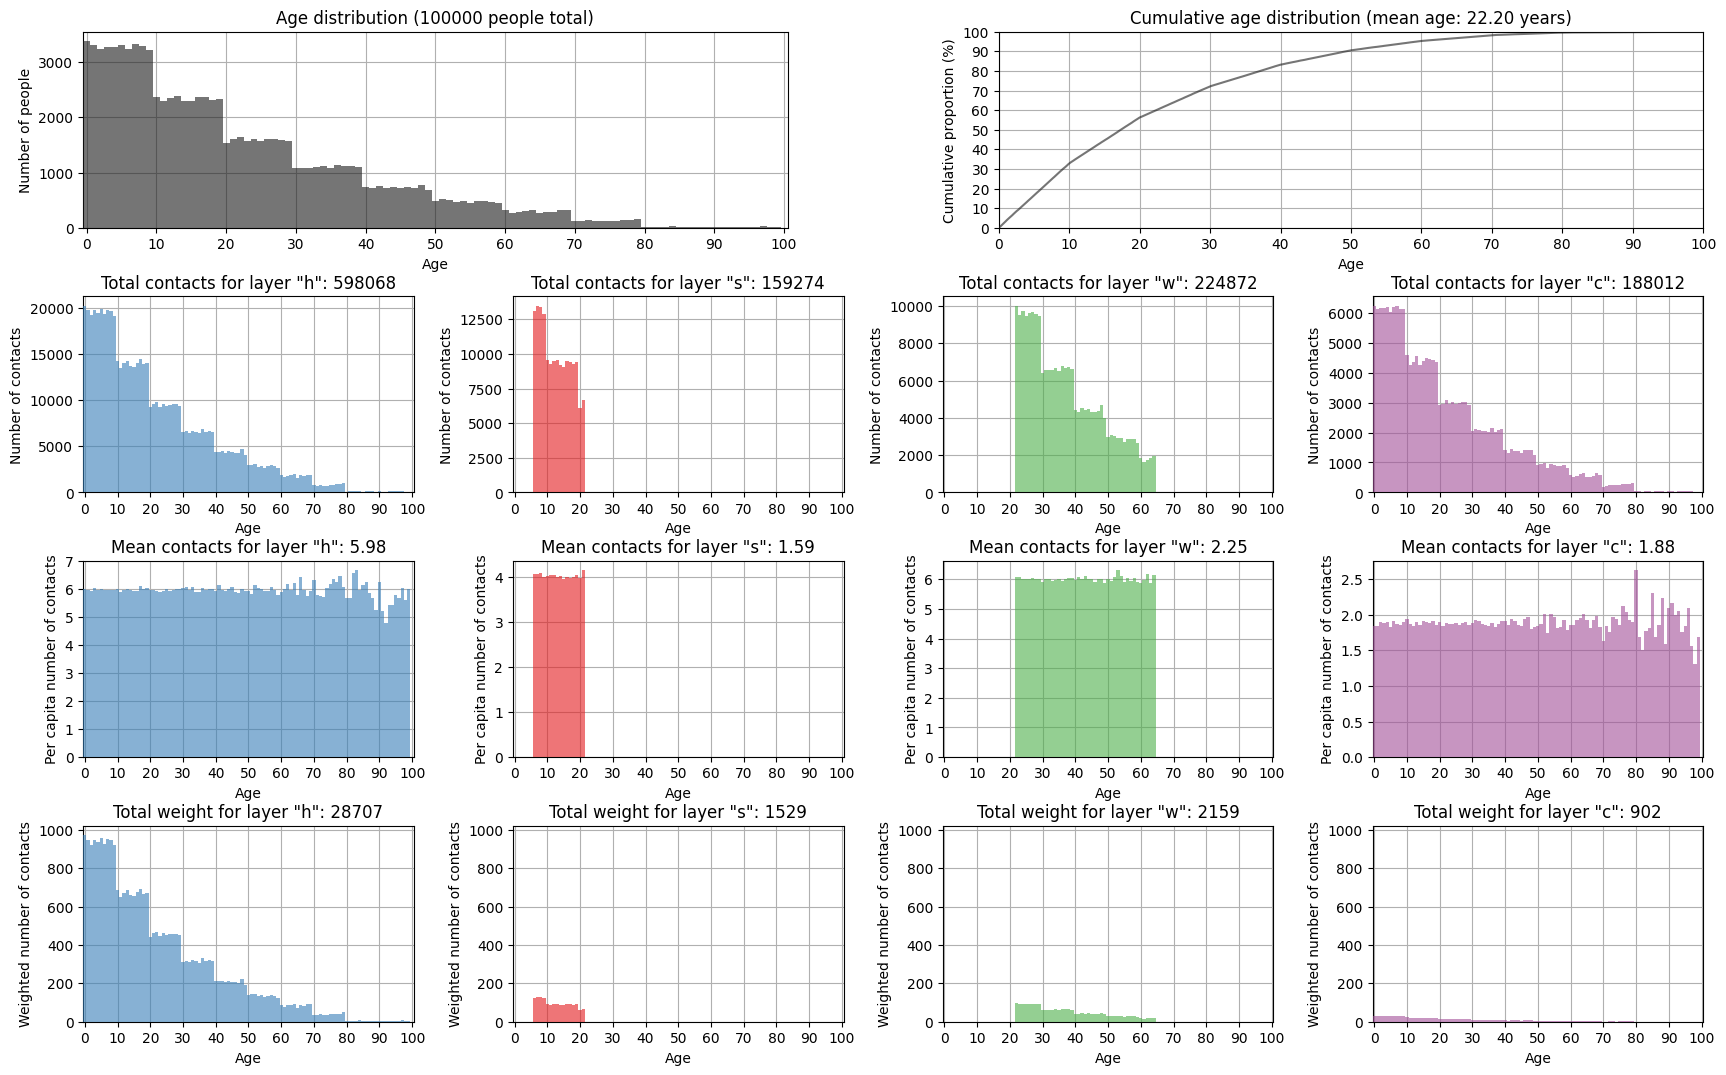

In [7]:
cv.options.set(dpi=100, show=False, close=True) #, verbose=0 # ) # put back in verbose once i've figured out what this does

# change the transmission rate (default beta value is 0.016?)
cb = cv.change_beta(days=['2020-04-06'], changes=[0.2]) 
# date that lockdown was imposed -- but would need to see how it impacted case numbers and compare
#sim = cv.Sim(pars, interventions=cb, label='With beta changes') # interventions=cb, label='With changes in RO from 6th April'
sim = cv.Sim(pars)

sim.initialize()
fig = sim.people.plot()

## 4. Run base simulation

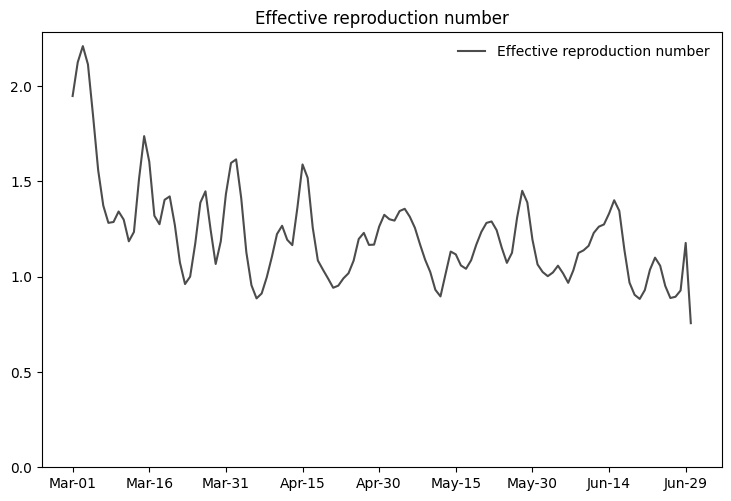

In [8]:
# just take a look at how changing beta changes the trajectory 
sim.run()
sim.plot_result('r_eff')

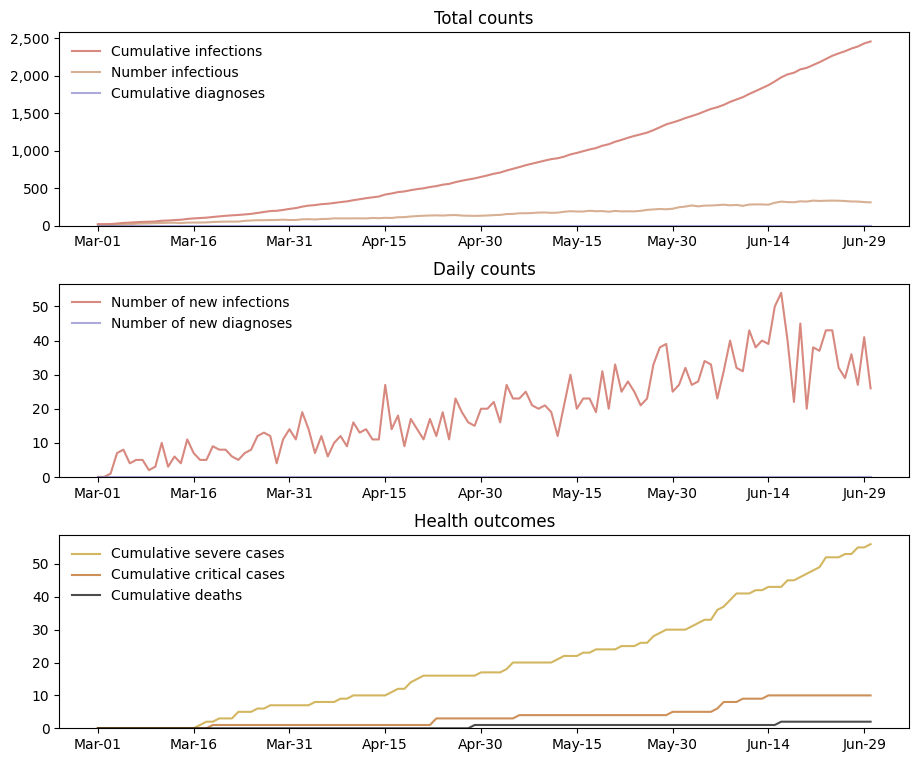

In [9]:
scenariofig = sim.plot()  
sim.plot()

In [ ]:

sim.save('outputs/drc-sim_base_r0.0001_zimcont.sim')
sim.to_excel('outputs/drc-sim_r0.0001_zimcont.xlsx')

## 4. Define comparative vaccination scenarios 

## a. Vaccinate only the over 65s

In [ ]:
def vaccinate_over65s(sim): # this is for any vaccination
   # if sim.t == sim.day('2020-04-15'): # i'm setting a situation where vaccination is introduced for all this age group on 15th
        elderly = sim.people.age >65
        sim.people.rel_sus[elderly] = 0.1 
        

## b. Vaccinate a proportion of the most mobile (15-65 yrs)

In [ ]:
def vaccinate_15_65(sim): # this is for any vaccination
   # if sim.t == sim.day('2020-04-15'): # i'm setting a situation where vaccination is introduced for all this age group on 15th
        young  = cv.true(sim.people.age < 14) # cv.true() returns indices of people matching this condition, i.e. people under 14
        middle = cv.true((sim.people.age >= 15) * (sim.people.age < 65))
        old = cv.true(sim.people.age >=65)
        inds = sim.people.uid
        vals=np.ones(len(sim.people))
        vals[young] = 0.0
        vals[middle] = 0.125
        vals[old]=0.0
        output = dict(inds=inds, vals=vals)
        return output
        # and it reduces their chances of severe disease by 90%
        
#define this as vaccine strategy two 
vaccine_s2 = cv.vaccine(days=20, rel_sus=0.1, rel_symp=0.06, subtarget=vaccinate_15_65)
### in reality, i don't think this can be called, because 'vaccine' is a specific name as below

## c. Vaccinate all the oldest and some subsections of younger generation

In [ ]:
# Define the vaccine subtargeting
def vaccinate_by_age(sim):
    young  = cv.true(sim.people.age < 14) # cv.true() returns indices of people matching this condition, i.e. people under 14
    middle = cv.true((sim.people.age >= 15) * (sim.people.age < 65))
    old = cv.true(sim.people.age >=65)
    inds = sim.people.uid
    vals=np.ones(len(sim.people))
    
    vals[young] = 0.025 # 2.5 % of people <14
    vals[middle] = 0.025 # 2.5 %  probability for people 15-65
    vals[old] = 1.0 # 90% probability for people >65
    output = dict(inds=inds, vals=vals)
    return output

# Define the vaccine strategy one
vaccine = cv.vaccine(days=20, rel_sus=0.1, rel_symp=0.06, subtarget=vaccinate_by_age )


## 5. Run simulation with scenarios included

In [ ]:
sim = cv.Sim(pars, interventions=cb, label = 'With changes in RO from 6th April')
sim2 = cv.Sim(pars, interventions=vaccinate_over65s, label = 'Vaccinate over 65s')
sim3 = cv.Sim(pars, interventions=vaccinate_15_65, label = 'Vaccinate 15-65s')
sim4 = cv.Sim(pars, interventions=vaccine, label = 'Vaccinate subgroups')
msim = cv.MultiSim([sim, sim2, sim3, sim4])
msim.run()


## 6. Plot results 

In [ ]:
fig2 = msim.plot(to_plot= ['cum_deaths', 'new_infections'])
# plots different scenarios against one another
msim.plot()

## 7. Save output

In [ ]:
filename = 'retro_scenarios.png'
cv.savefig(filename) # Save including version information
cv.get_png_metadata(filename) # Retrieve and print information

# for some reason this is still blank

In [ ]:
sim2.initialize()
sim2.run()
sim2.save('drc-sim_vaccinate65s.sim')
sim2.to_excel('drc-sim_vaccinate65s.xlsx')

In [ ]:
sim3.run()
sim3.save('drc-sim_vaccinate_15-65s.sim')
sim3.to_excel('drc-sim_vaccinate_15-65s.xlsx')

In [ ]:
sim4.run()
sim4.save('drc-sim_vaccinate_subgroups.sim')
sim4.save('drc-sim_vaccinate_subgroups.xlsx')